In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [22]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.dialects.mssql import DATE
from datetime import datetime, timedelta


In [24]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [25]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [26]:
# Print all of the classes mapped to the Base
Base.classes.keys()


['measurement', 'station']

In [27]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`

Measurement = Base.classes.measurement
Station = Base.classes.station


In [28]:
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
list_dates = session.query(Measurement.date)
for row in list_dates.order_by(Measurement.date.desc()).limit(1):
   print(row)

('2017-08-23',)


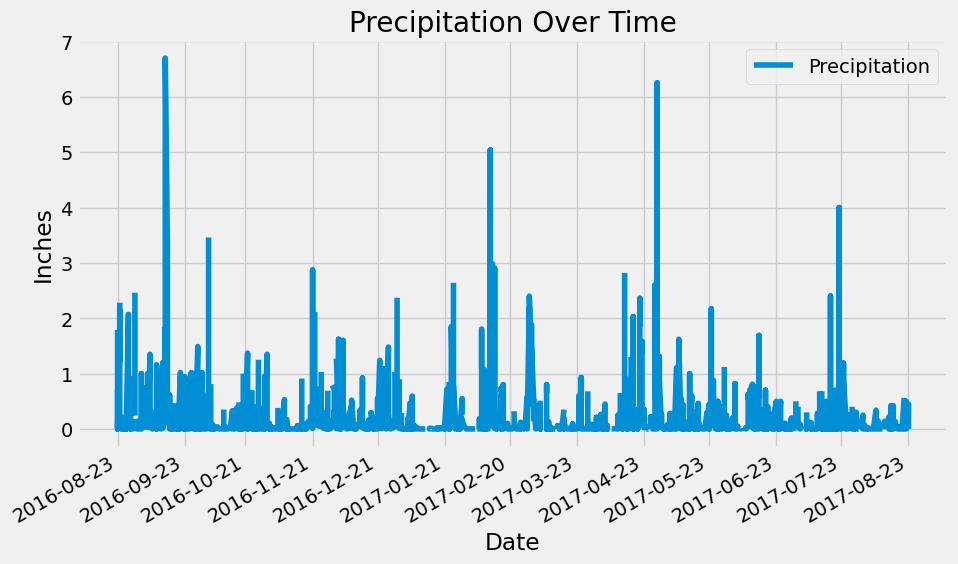

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

last_12 = session.query(Measurement.date, Measurement.prcp) \
        .where(Measurement.date >= (dt.date(2017, 8, 23) - dt.timedelta(days=365))) \
        .order_by(Measurement.date.desc())


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12, columns=['Date', 'Precipitation'])


# Sort the DataFrame by date
df_sorted = df.sort_values(by='Date')


# Use Pandas Plotting with Matplotlib to plot the data
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Date'], df_sorted['Precipitation'], label='Precipitation', linestyle='-')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Inches')
locator = mdates.AutoDateLocator(minticks=10, maxticks=15)
plt.gca().xaxis.set_major_locator(locator)
# Formatting the x-axis date labels
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df_sorted['Precipitation'].describe()

# Display the summary statistics
print(summary_statistics)


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
count_stations = session.query(Station.name).distinct().count()
print(f"Number of Stations: {count_stations}")

Number of Stations: 9


In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(Station.name, func.count()).filter(Station.station == Measurement.station)\
    .group_by(Station.name).order_by(func.count()).all()

for record in station_count:
    print(record)

('UPPER WAHIAWA 874.3, HI US', 511)
('PEARL CITY, HI US', 1372)
('HONOLULU OBSERVATORY 702.2, HI US', 1979)
('KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('MANOA LYON ARBO 785.2, HI US', 2612)
('WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('KANEOHE 838.1, HI US', 2709)
('WAIKIKI 717.2, HI US', 2724)
('WAIHEE 837.5, HI US', 2772)


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Query for temperature data for the specified station
temperature_data = (
    session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
    .filter(Measurement.station == 'USC00519281')
    .all()
)

# Print the results
min_temp, max_temp, avg_temp = temperature_data[0]
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


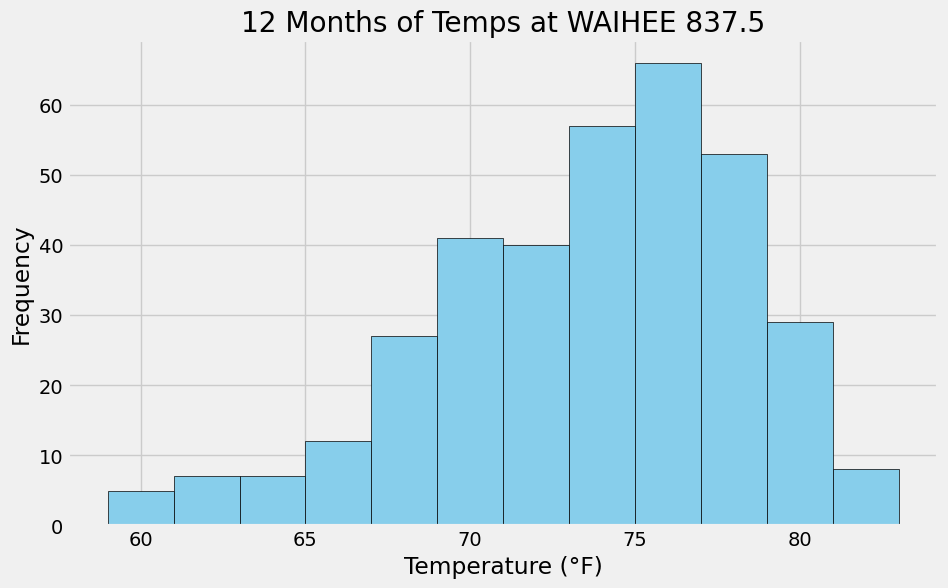

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281') \
        .where(Measurement.date >= (dt.date(2017, 8, 23) - dt.timedelta(days=365))) \
        .order_by(Measurement.date.desc())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_temp = pd.DataFrame(last_12_temp, columns=['Date', 'Temperature'])


# Sort the DataFrame by date
df_temp_sorted = df_temp.sort_values(by='Date')


# Use Pandas Plotting with Matplotlib to plot the data
# Plotting

plt.figure(figsize=(10, 6))
plt.hist(df_temp_sorted['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.title('12 Months of Temps at WAIHEE 837.5')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [36]:
# Close Session
session.close()
